# 16 Extracting Interfaces from Geological Maps

Geological Maps nowadays are usually available in a vector format consisting of connected polygons. These polygons consist of single vertices and hence, boundaries between younger and older stratigraphic units can be used for modeling. However, these specific vertices need to be kept while removing all unnecessary ones. The following will introduce how that works in GemGIS. 

<img src="../images/tutorial16_cover.png">

## Set File Paths and download Tutorial Data

If you downloaded the latest `GemGIS` version from the Github repository, append the path so that the package can be imported successfully. Otherwise, it is recommended to install `GemGIS` via `pip install gemgis` and import `GemGIS` using `import gemgis as gg`. In addition, the file path to the folder where the data is being stored is set. The tutorial data is downloaded using Pooch (https://www.fatiando.org/pooch/latest/index.html) and stored in the specified folder. Use `pip install pooch` if Pooch is not installed on your system yet.

In [1]:
import gemgis as gg

file_path ='data/16_extracting_interfaces_from_geological_maps/'

In [2]:
gg.download_gemgis_data.download_tutorial_data(filename="16_extracting_interfaces_from_geological_maps.zip", dirpath=file_path)

## Loading Data

A simple geological map will be used to demonstrate the feature.

In [3]:
import geopandas as gpd

gmap = gpd.read_file(file_path + 'interfaces_polygons.shp')
gmap

,id,formation,geometry
0,None,Sand1,"POLYGON ((0.25633 264.86215, 10.59347 276.7337..."
1,None,Ton,"POLYGON ((0.25633 264.86215, 0.18819 495.78721..."
2,None,Sand2,"POLYGON ((0.18819 495.78721, 0.24897 1068.7595..."
3,None,Sand2,"POLYGON ((511.67477 1068.85246, 971.69794 1068..."


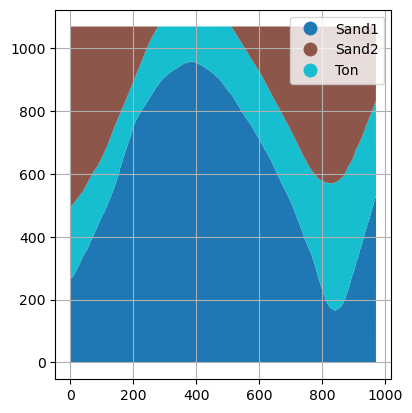

In [4]:
import matplotlib.pyplot as plt

gmap.plot(column='formation', aspect='equal', legend=True)
plt.grid()

## Sorting the GeoDataFrame by stratigraphic age

The probably most important step of this workflow is to sort the stratigraphic units according to their age. This can be done using the function ``sort_by_stratigraphy(..)`` and by providing a list with the formations in stratigraphic order from young to old.



In [5]:
stratigraphy = ['Sand2', 'Ton', 'Sand1']

gmap_sorted = gg.vector.sort_by_stratigraphy(gdf=gmap,
                                             stratigraphy=stratigraphy)

gmap_sorted

,id,formation,geometry
0,None,Sand2,"POLYGON ((0.18819 495.78721, 0.24897 1068.7595..."
1,None,Sand2,"POLYGON ((511.67477 1068.85246, 971.69794 1068..."
2,None,Ton,"POLYGON ((0.25633 264.86215, 0.18819 495.78721..."
3,None,Sand1,"POLYGON ((0.25633 264.86215, 10.59347 276.7337..."


## Extracting Intersections from Polygons

The functionality is mainly based on the intersections between Shapely Polygons which will be demonstrated below. 

### Intersections between two polygons

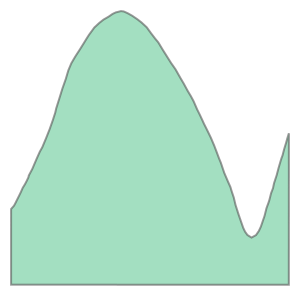

In [6]:
gmap_sorted.loc[3].geometry

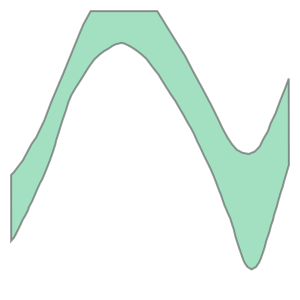

In [7]:
gmap_sorted.loc[2].geometry

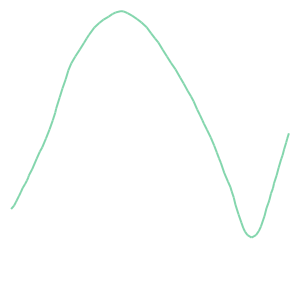

In [8]:
intersection = gg.vector.intersection_polygon_polygon(polygon1=gmap_sorted.loc[3].geometry,
                                                      polygon2=gmap_sorted.loc[2].geometry)
intersection

### Intersections between a polygon and polygons

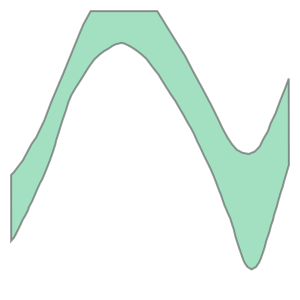

In [9]:
gmap_sorted.loc[2].geometry

In [10]:
poly_list=[gmap_sorted.loc[1].geometry, gmap_sorted.loc[0].geometry]
poly_list

[<POLYGON ((511.675 1068.852, 971.698 1068.8, 971.738 832.976, 959.372 800.02...>,
 <POLYGON ((0.188 495.787, 0.249 1068.76, 278.524 1068.772, 265.602 1045.513,...>]

In [11]:
intersection = gg.vector.intersections_polygon_polygons(polygon1=gmap_sorted.loc[2].geometry,
                                                        polygons2=poly_list)
intersection_gdf = gpd.GeoDataFrame(geometry=intersection)
intersection_gdf

,geometry
0,"MULTILINESTRING ((511.675 1068.852, 526.375 10..."
1,"MULTILINESTRING ((0.188 495.787, 8.841 504.142..."


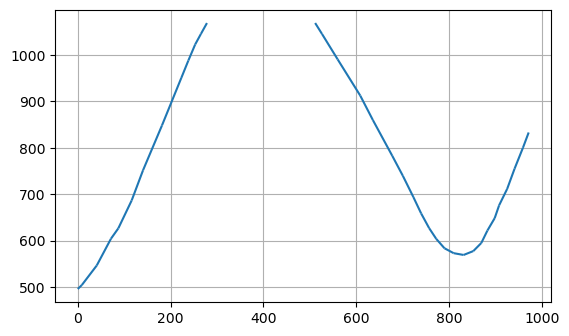

In [12]:
intersection_gdf.plot()
plt.grid()

### Intersections between polygons and polygons

In [13]:
gdf1 = gpd.GeoDataFrame(geometry=[gmap_sorted.loc[2].geometry])
gdf1

,geometry
0,"POLYGON ((0.256 264.862, 0.188 495.787, 8.841 ..."


In [14]:
gdf2 = gpd.GeoDataFrame(geometry=[gmap_sorted.loc[1].geometry, gmap_sorted.loc[0].geometry])
gdf2

,geometry
0,"POLYGON ((511.675 1068.852, 971.698 1068.800, ..."
1,"POLYGON ((0.188 495.787, 0.249 1068.760, 278.5..."


In [15]:
intersection = gg.vector.intersections_polygons_polygons(polygons1=gdf1,
                                                         polygons2=gdf2)

intersection_gdf = gpd.GeoDataFrame(geometry=intersection)
intersection_gdf

,geometry
0,"MULTILINESTRING ((511.675 1068.852, 526.375 10..."
1,"MULTILINESTRING ((0.188 495.787, 8.841 504.142..."


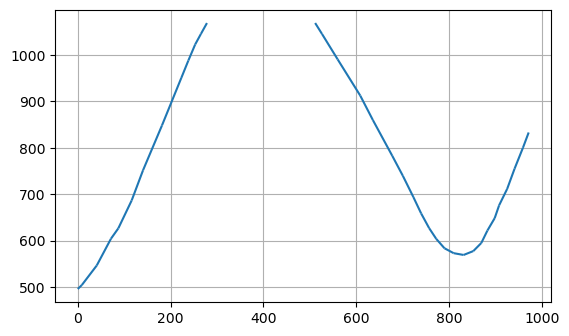

In [16]:
intersection_gdf.plot()
plt.grid()

## Extracting Interfaces from Geological Map

The final step is to use the entire GeoDataFrame for the extraction of the intersections. The resulting GeoDataFrame only contains interfaces of formations that also have a base. Therefore, interfaces of ``Sand1`` are missing as this formation represents the basement of the stratigraphy.

In [17]:
intersection = gg.vector.extract_xy_from_polygon_intersections(gdf=gmap_sorted)

intersection

,id,formation,geometry
0,None,Sand2,"MULTILINESTRING ((278.52378 1068.77171, 265.60..."
1,None,Sand2,"MULTILINESTRING ((971.73811 832.97587, 959.372..."
2,None,Ton,"MULTILINESTRING ((972.08890 529.79176, 966.073..."


When plotting the data, it can be seen that there are three different boundaries. First, there is the base of ``Ton`` and then twice the base of ``Sand2``. 

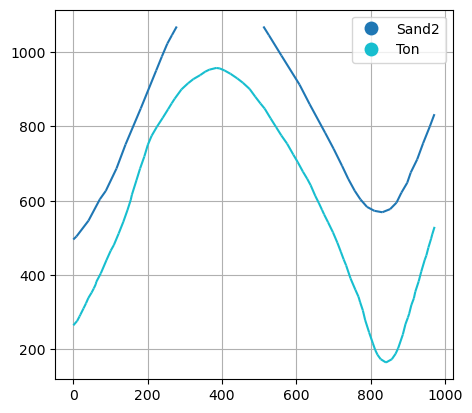

In [18]:
intersection.plot(column='formation', aspect='equal', legend=True)
plt.grid()